In [29]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics.pairwise import linear_kernel
import warnings

nltk.download('punkt')
snow_stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploring and visualizing our dataset

In [43]:
dataset=pd.read_csv("/content/drive/MyDrive/IMDB.csv") # this is the original dataset

In [44]:
dataset.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [45]:
# we join the reviews together so that we can generate the wordcloud
text = " ".join(review for review in dataset['review'])

In [46]:
#we convert the STOPWORDS to a set because looking up an element in a set is more efficient 
stopwords = set(STOPWORDS)


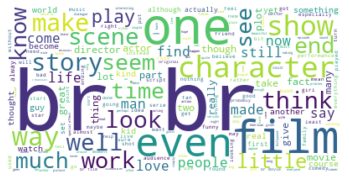

In [47]:

# we geenrate the world cloud and realize that our dataset is noisy with stopwords and the <br> html tag , so we add them to the stop word set to make it more coherent
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [34]:
stopwords.update(["br","even","one"]) #this is to add the other common stopwords

In [19]:
#we create a new column
dataset['phrase_len'] = dataset['review'].apply(lambda row:len(row)) 
#we replace the strings with 0 and 1
dataset["sentiment"].replace({"positive": 1, "negative": 0}, inplace=True)


In [ ]:
dataset['phrase_len'].min()  #sanity check

32

# Text preprocessing and normalization

In [20]:
dataset["review"] = dataset["review"].str.lower()  #we make sure that all the words are in low-case

#dataset['review']=dataset['review'].apply(lambda row:word_tokenize(row)) #we tokenize our sentences into words
dataset['review']=dataset['review'].str.split()
dataset['review']=dataset['review'].apply(lambda row:[w for w in row if  w.isalpha()]) # we clean our text from anything other than alphabetical words
dataset['review']=dataset['review'].apply(lambda row:[w for w in row if  not w in stopwords]) # we remove the stopwords

In [21]:
dataset["review"]

0        [reviewers, mentioned, watching, oz, episode, ...
1        [wonderful, little, filming, technique, fashio...
2        [thought, wonderful, way, spend, time, hot, su...
3        [basically, family, little, boy, thinks, zombi...
4        [petter, time, visually, stunning, film, matte...
                               ...                        
49995    [thought, movie, right, good, creative, origin...
49996    [bad, bad, bad, idiotic, annoying, porn, groov...
49997    [catholic, taught, parochial, elementary, scho...
49998    [going, disagree, previous, comment, side, mal...
49999    [expects, star, trek, movies, high, fans, expe...
Name: review, Length: 50000, dtype: object

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
dataset['review']=dataset['review'].apply(lambda lignes : [lemmatizer.lemmatize(mot) for mot in lignes ]) #lemmetization version

In [ ]:
#dataset_stem['review'] = dataset_stem['review'].apply(lambda lignes: [snow_stemmer.stem(mot) for mot in lignes]) # stemming version

In [24]:
dataset['review']=dataset['review'].apply(lambda x:" ".join(x)) # we join the strings back into one single string so that we're able to apply TF-IDF

*since Lemmatization refers to doing things properly with the use of a vocabulary and morphological analysis of words , i chose to work with the lemmatization version in order to improve the results at the expense of the extra time needed.*

In [ ]:
ds.to_csv("dataset_lem.csv", encoding='utf-8', index=False) #to save the work locally

# classifying reviews using TF-IDF

In [ ]:
#this is to calculate tf-idf without any optimization
tf=TfidfVectorizer()
X = tf.fit_transform(ds['review'])
print(X.shape)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(dataset['review'],dataset['sentiment'],test_size=0.3)
#we split the dataset 

In [ ]:
# we use gridsearch to get the best parameters for our model
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC()),
])
parameters = {
    'tfidf__max_df': (0.25,0.35,0.5, 0.75),
    'tfidf__min_df': [5,10,15,20,25,50],
    
    
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train,y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done  48 out of  48 | elapsed:  2.8min finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]


In [40]:
tf=TfidfVectorizer(min_df=5,max_df=0.75) # we pick the best parameters based on the grid search

In [ ]:
# we make a pipeline object for our model
pipeline_tf=Pipeline([('tf-idf',tf),
           ('clf',LinearSVC())
          
          ])
model_tf=pipeline_tf.fit(X_train,y_train)
predicted_tf=model_tf.predict(X_test)



In [ ]:
report_tf=classification_report(y_test,predicted_tf) #we finally get our results 
print(report_tf)

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7500
           1       0.89      0.90      0.89      7500

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000



# now we create a similarity function along with a preprocessing function for our phrase

In [35]:
def preprocess_phrase(phrase):
  phrase=phrase.lower().split() # we lower the case
  #phrase=phrase.split() # this is to tokenize the sentence
  clean_phrase=[lemmatizer.lemmatize(i) for i in phrase if i.isalpha() and i not in stopwords]
  clean_phrase_str=" ".join(clean_phrase)
  return clean_phrase_str
# this is an example on the output of the function
preprocess_phrase("I love star trek br br </> ")
# this function is made to preprocess the sentence before adding it to the dataframe

'love star trek'

In [38]:
def get_similaire_tf(phrase):
  preprocess_phrase(phrase)
  new_row = {'review':phrase} #we create a new row with our query
  df=dataset.copy()          #we make sure to copy the dataset in order to append
  df.append(new_row,ignore_index=True) #we append our phrase to the dataframe
  X = tf.fit_transform(df['review']) #we apply TF-IDF
  cosine_similarities = linear_kernel(X[-1:],X).flatten() # we calculate cosine similarity between our query and the entire dataset
  related_docs_indices = cosine_similarities.argsort()[:-6:-1] # we pick our top 5 indices
  related_docs_indices
  phrases=[]
  for i in related_docs_indices:
    phrases.append(df['review'][i])
  return phrases
  






In [41]:
get_similaire_tf("I love star trek 1231561 br br >/<") # we can see that the function is working properly and it's returning a clean phrase

['expects star trek movie high fan expect movie good best movie implausible plot left cringing far worst nine chance watch well known character interact another movie save movie including goofy scene spock mccoy say movie worth hardly worth true fan need see renting movie way see cable channel avoid',
 'huge fan original crew enterprise eight year watched movie appreciated retained old series developing character star trek undiscovered thought aging character well handled story worthy theatrical said trek final easily worst series featuring original agree many camaraderie spock mccoy well overall direction william shatner special effect worthy anything television almost unrecognizable star trek action sequence sustained build little dialogue weak though provide intended seem thrown whole concept silly laurence fine actor everything seen boarder absurd scene sybok conjures image pain pain shatters image character known spock never party stupidity trying save father full redundant dialog

# now we repeat the same work using bag of words


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()   
X = bow.fit_transform(dataset['review'])
X.shape

(50000, 87357)

In [ ]:
from sklearn.model_selection import GridSearchCV #we used gridsearch to pick BOW parameters
pipeline = Pipeline([
    ('BOW',CountVectorizer()),
    ('clf', LinearSVC()),
])
parameters = {
    'BOW__ngram_range': [(1,1),(2,2)],
    'BOW__min_df':[5,15,20,50],
    
    
    
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(X_train,y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  16 out of  16 | elapsed:  2.1min finished


Best parameters set:
[('BOW', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)), ('clf', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0))]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
pipeline_bow=Pipeline([('bag of words',CountVectorizer(min_df=5)),  
           ('clf',LinearSVC(dual=True))
          
          ])
model_bow=pipeline_bow.fit(X_train,y_train)
predicted_bow=model_bow.predict(X_test)



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
report_bow = classification_report(y_test, predicted_bow)
print(report_bow)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7500
           1       0.85      0.86      0.86      7500

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



In [ ]:
# similarity function using BOW
def get_similaire_bow(phrase):
  preprocess_phrase(phrase)
  new_row = {'review':phrase}
  bow = CountVectorizer(ngram_range=(2,2)) # the ngram_range has to be at least 2 for this function to perform moderately well
  df=dataset.copy()
  df.append(new_row,ignore_index=True)
  X = bow.fit_transform(df['review'])
  cosine_similarities = linear_kernel(X[-1:],X).flatten()
  related_docs_indices = cosine_similarities.argsort()[:-6:-1]
  related_docs_indices
  phrases=[]
  for i in related_docs_indices:
    phrases.append(df['review'][i])
  return phrases
  # the function return the phrases that the most similaire to the input , but we can also return the indices





In [ ]:
get_similaire_bow("i love star trek  br br 15477 /*<") 

['star trek v definitely earns dubious distinction weakest film star trek series despite good acting effort actor suffered general lack funding paramount picture paramount picture enthusiastic film movie begin enterprise crew enjoying extended shore leave reword saving earth total ecological disaster shore leave cut short disturbance occurs nimbus iii planet intergalactic peace captain kirk enterprise arrive nimbus iii ship hijacked sybok spock sybok brainwashes crew enterprise set suicide mission rendezvous god past great barrier center galaxy captain kirk must figure way regain control ship fend enterprise klignon bright spot film acting directing william shatner leonard nimoy deforest kelley laurence luckinbill rest cast give good performance william shatner pretty good job directing film suffered general lack enthusiasm funding first part sybok initially offered sean connery refused laurence luckinbill got part second many special effect severely cut back reducing movie entertainin

*By comparing the results we can see that TF-idf performs better than BOW and yields better results this is due to the fact that TF-IDF gives less importance to the most common words which are often not imporant in sentiment analysis
unlike BOW which only counts the words occurences*